In [43]:
!cd /kaggle/working/
!rm -rf *

In [44]:
import shutil
import os

input_path = "/kaggle/input/realwaste-dataset/realwaste-main/RealWaste"

working_path = "/kaggle/working/realwaste"

shutil.copytree(input_path, working_path, dirs_exist_ok=True)

print("Dataset copied successfully to working directory!")

Dataset copied successfully to working directory!


In [45]:
base_dir = "/kaggle/working/realwaste"
for folder in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, folder)))
    print(f"{folder}: {count} images")

Paper: 500 images
Textile Trash: 318 images
Metal: 790 images
Cardboard: 461 images
Food Organics: 411 images
Miscellaneous Trash: 495 images
Glass: 420 images
Plastic: 921 images
Vegetation: 436 images


In [46]:
!pip install split-folders

In [47]:
import splitfolders

input_folder = "/kaggle/working/realwaste"
output_folder = "/kaggle/working/realwaste-split"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

Copying files: 4752 files [00:01, 4318.73 files/s]


In [48]:
base_dir = "/kaggle/working/realwaste-split"

for split in ['train', 'val', 'test']:
    split_path = os.path.join(base_dir, split)
    print(f"\n{split.upper()} SET")
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))

        total += count
        print(f"  {cls}: {count} images")
    print(f"Total {split}: {total} images")


TRAIN SET
  Paper: 350 images
  Textile Trash: 222 images
  Metal: 553 images
  Cardboard: 322 images
  Food Organics: 287 images
  Miscellaneous Trash: 346 images
  Glass: 294 images
  Plastic: 644 images
  Vegetation: 305 images
Total train: 3323 images

VAL SET
  Paper: 75 images
  Textile Trash: 47 images
  Metal: 118 images
  Cardboard: 69 images
  Food Organics: 61 images
  Miscellaneous Trash: 74 images
  Glass: 63 images
  Plastic: 138 images
  Vegetation: 65 images
Total val: 710 images

TEST SET
  Paper: 75 images
  Textile Trash: 49 images
  Metal: 119 images
  Cardboard: 70 images
  Food Organics: 63 images
  Miscellaneous Trash: 75 images
  Glass: 63 images
  Plastic: 139 images
  Vegetation: 66 images
Total test: 719 images


In [49]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

# IMAGENET_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((192, 192)),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

train_dataset = datasets.ImageFolder("/kaggle/working/realwaste-split/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("/kaggle/working/realwaste-split/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder("/kaggle/working/realwaste-split/test", transform=val_test_transforms)

# Get number of classes and device early
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")

Using device: cuda
Number of classes: 9


In [50]:
class_counts = np.bincount(train_dataset.targets)
print("Class counts:", class_counts)

class_weights_tensor = 1. / torch.tensor(class_counts, dtype=torch.float)

sample_weights = [class_weights_tensor[label].item() for label in train_dataset.targets]

print("\nClass counts per category:")
for cls, count in zip(train_dataset.classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\nClass weights (inverse of frequency):")
for cls, w in zip(train_dataset.classes, class_weights_tensor):
    print(f"  {cls:15s}: {w:.6f}")

Class counts: [322 287 294 553 346 350 644 222 305]

Class counts per category:
  Cardboard      : 322
  Food Organics  : 287
  Glass          : 294
  Metal          : 553
  Miscellaneous Trash: 346
  Paper          : 350
  Plastic        : 644
  Textile Trash  : 222
  Vegetation     : 305

Class weights (inverse of frequency):
  Cardboard      : 0.003106
  Food Organics  : 0.003484
  Glass          : 0.003401
  Metal          : 0.001808
  Miscellaneous Trash: 0.002890
  Paper          : 0.002857
  Plastic        : 0.001553
  Textile Trash  : 0.004505
  Vegetation     : 0.003279


In [51]:
BATCH_SIZE = 64

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


print(f"\nWeightedRandomSampler created successfully!")
print(f"Total samples in epoch: {len(sample_weights)}")
print(f"Training Batch size: {train_loader.batch_size}")
print(f"Validation Batch size: {val_loader.batch_size}")
print(f"Total training batches per epoch: {len(train_loader)}")


WeightedRandomSampler created successfully!
Total samples in epoch: 3323
Training Batch size: 64
Validation Batch size: 64
Total training batches per epoch: 52


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy

class WasteCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(WasteCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self._to_linear = None
        self.calculate_flatten_size(192)

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def calculate_flatten_size(self, input_size):
        with torch.no_grad():
            x = torch.zeros(1, 3, input_size, input_size)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, self._to_linear)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

print("WasteCNN model class defined and ready for use.")

WasteCNN model class defined and ready for use.


In [53]:

def get_fresh_model_for_comparison(num_classes, device, base_model_path='initial_model_weights.pth'):
    if not os.path.exists(base_model_path):
        initial_model = WasteCNN(num_classes=num_classes).to(device)
        torch.save(initial_model.state_dict(), base_model_path)
        print(f"Created and saved initial model weights to {base_model_path}")
        return initial_model
    else:
        new_model = WasteCNN(num_classes=num_classes).to(device)
        new_model.load_state_dict(torch.load(base_model_path))
        return new_model

def run_optimizer_training_comparison(model_instance, optimizer_name, optimizer_obj, criterion_obj, scheduler_obj, num_epochs_comp, train_loader_comp, val_loader_comp, device_comp):
    print(f"\nTraining with {optimizer_name} for {num_epochs_comp} epochs...")

    current_train_losses = []
    current_train_accuracies = []
    current_val_losses = []
    current_val_accuracies = []

    best_val_acc_run = 0.0
    model_path_run = f'best_model_comparison_{optimizer_name.lower().replace(" ", "_").replace("-", "_")}.pth'

    for epoch in range(num_epochs_comp):
        model_instance.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)

            optimizer_obj.zero_grad()
            outputs = model_instance(images)
            loss = criterion_obj(outputs, labels)
            loss.backward()
            optimizer_obj.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_loop.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader_comp.dataset)
        epoch_train_accuracy = 100 * train_correct / train_total
        current_train_losses.append(epoch_train_loss)
        current_train_accuracies.append(epoch_train_accuracy)

        if scheduler_obj:
            scheduler_obj.step()

        model_instance.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            val_loop = tqdm(val_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device_comp), labels.to(device_comp)
                outputs = model_instance(images)
                loss = criterion_obj(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader_comp.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        current_val_losses.append(epoch_val_loss)
        current_val_accuracies.append(epoch_val_accuracy)

        print(f"  {optimizer_name} - Epoch [{epoch+1}/{num_epochs_comp}] "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_accuracy:.2f}%")

        if epoch_val_accuracy > best_val_acc_run:
            best_val_acc_run = epoch_val_accuracy
            torch.save(model_instance.state_dict(), model_path_run)

    print(f"--- {optimizer_name} training finished. Best Val Accuracy: {best_val_acc_run:.2f}% ---")
    return current_train_losses, current_train_accuracies, current_val_losses, current_val_accuracies, model_path_run

In [54]:
print("\n" + "="*75)
print("       Starting Optimizer Performance Comparison Training       ")
print("="*75 + "\n")

_ = get_fresh_model_for_comparison(num_classes, device)

NUM_EPOCHS_COMP = 20
criterion_comp = nn.CrossEntropyLoss()

# 1. Adam Optimizer Configuration
model_adam_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_adam_comp = optim.Adam(model_adam_comp.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler_adam_comp = StepLR(optimizer_adam_comp, step_size=10, gamma=0.1)

# 2. Standard SGD Optimizer Configuration
model_sgd_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_sgd_comp = optim.SGD(model_sgd_comp.parameters(), lr=0.005, weight_decay=1e-4)
scheduler_sgd_comp = StepLR(optimizer_sgd_comp, step_size=10, gamma=0.1)

# 3. SGD with Momentum Optimizer Configuration
model_sgd_momentum_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_sgd_momentum_comp = optim.SGD(model_sgd_momentum_comp.parameters(), lr=0.0005, momentum=0.75, weight_decay=1e-4)
scheduler_sgd_momentum_comp = StepLR(optimizer_sgd_momentum_comp, step_size=10, gamma=0.1)

# 4. RMSProp Optimizer Configuration
model_rmsprop_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_rmsprop_comp = optim.RMSprop(model_rmsprop_comp.parameters(), lr=5e-5, alpha=0.8, weight_decay=1e-4)
scheduler_rmsprop_comp = StepLR(optimizer_rmsprop_comp, step_size=10, gamma=0.1)


# ===================== TRAINING =====================
adam_results = run_optimizer_training_comparison(
    model_adam_comp, "Adam", optimizer_adam_comp, criterion_comp, scheduler_adam_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
adam_train_losses, adam_train_accuracies, adam_val_losses, adam_val_accuracies, adam_comp_model_path = adam_results


sgd_results = run_optimizer_training_comparison(
    model_sgd_comp, "Standard SGD", optimizer_sgd_comp, criterion_comp, scheduler_sgd_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_train_losses, sgd_train_accuracies, sgd_val_losses, sgd_val_accuracies, sgd_comp_model_path = sgd_results


sgd_momentum_results = run_optimizer_training_comparison(
    model_sgd_momentum_comp, "SGD with Momentum", optimizer_sgd_momentum_comp, criterion_comp, scheduler_sgd_momentum_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_momentum_train_losses, sgd_momentum_train_accuracies, sgd_momentum_val_losses, sgd_momentum_val_accuracies, sgd_momentum_comp_model_path = sgd_momentum_results


rmsprop_results = run_optimizer_training_comparison(
    model_rmsprop_comp, "RMSProp", optimizer_rmsprop_comp, criterion_comp, scheduler_rmsprop_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
rmsprop_train_losses, rmsprop_train_accuracies, rmsprop_val_losses, rmsprop_val_accuracies, rmsprop_comp_model_path = rmsprop_results


print("\nOptimizer comparison training completed for all models.")



       Starting Optimizer Performance Comparison Training       

Created and saved initial model weights to initial_model_weights.pth

Training with Adam for 20 epochs...


  Adam - Epoch [1/20] Train Loss: 1.6548 | Train Acc: 40.45% | Val Loss: 1.5959 | Val Accuracy: 38.87%


  Adam - Epoch [2/20] Train Loss: 1.3164 | Train Acc: 53.78% | Val Loss: 1.2802 | Val Accuracy: 54.65%


  Adam - Epoch [3/20] Train Loss: 1.1380 | Train Acc: 59.25% | Val Loss: 1.1794 | Val Accuracy: 58.31%


  Adam - Epoch [4/20] Train Loss: 0.9830 | Train Acc: 65.90% | Val Loss: 1.1591 | Val Accuracy: 58.87%


  Adam - Epoch [5/20] Train Loss: 0.9137 | Train Acc: 68.58% | Val Loss: 1.0313 | Val Accuracy: 65.77%


  Adam - Epoch [6/20] Train Loss: 0.8207 | Train Acc: 72.28% | Val Loss: 1.0343 | Val Accuracy: 64.51%


  Adam - Epoch [7/20] Train Loss: 0.7363 | Train Acc: 74.84% | Val Loss: 0.9893 | Val Accuracy: 68.17%


  Adam - Epoch [8/20] Train Loss: 0.6799 | Train Acc: 77.70% | Val Loss: 0.9700 | Val Accuracy: 67.18%


  Adam - Epoch [9/20] Train Loss: 0.6314 | Train Acc: 79.39% | Val Loss: 0.9396 | Val Accuracy: 68.59%


  Adam - Epoch [10/20] Train Loss: 0.5522 | Train Acc: 82.88% | Val Loss: 0.9247 | Val Accuracy: 68.17%


  Adam - Epoch [11/20] Train Loss: 0.4790 | Train Acc: 86.04% | Val Loss: 0.8821 | Val Accuracy: 70.14%


  Adam - Epoch [12/20] Train Loss: 0.4821 | Train Acc: 85.80% | Val Loss: 0.8701 | Val Accuracy: 70.85%


  Adam - Epoch [13/20] Train Loss: 0.4608 | Train Acc: 86.91% | Val Loss: 0.8734 | Val Accuracy: 70.85%


  Adam - Epoch [14/20] Train Loss: 0.4531 | Train Acc: 87.18% | Val Loss: 0.8751 | Val Accuracy: 70.99%


  Adam - Epoch [15/20] Train Loss: 0.4482 | Train Acc: 87.33% | Val Loss: 0.8636 | Val Accuracy: 70.56%


  Adam - Epoch [16/20] Train Loss: 0.4520 | Train Acc: 87.57% | Val Loss: 0.8560 | Val Accuracy: 71.69%


  Adam - Epoch [17/20] Train Loss: 0.4455 | Train Acc: 87.66% | Val Loss: 0.8513 | Val Accuracy: 71.13%


  Adam - Epoch [18/20] Train Loss: 0.4253 | Train Acc: 88.44% | Val Loss: 0.8633 | Val Accuracy: 71.27%


  Adam - Epoch [19/20] Train Loss: 0.4215 | Train Acc: 88.26% | Val Loss: 0.8577 | Val Accuracy: 71.27%


  Adam - Epoch [20/20] Train Loss: 0.4400 | Train Acc: 87.84% | Val Loss: 0.8435 | Val Accuracy: 72.25%
--- Adam training finished. Best Val Accuracy: 72.25% ---

Training with Standard SGD for 20 epochs...


  Standard SGD - Epoch [1/20] Train Loss: 1.8463 | Train Acc: 33.22% | Val Loss: 1.7888 | Val Accuracy: 32.39%


  Standard SGD - Epoch [2/20] Train Loss: 1.4214 | Train Acc: 49.38% | Val Loss: 1.4749 | Val Accuracy: 45.07%


  Standard SGD - Epoch [3/20] Train Loss: 1.2399 | Train Acc: 55.28% | Val Loss: 1.2699 | Val Accuracy: 53.24%


  Standard SGD - Epoch [4/20] Train Loss: 1.1236 | Train Acc: 59.22% | Val Loss: 1.2141 | Val Accuracy: 56.76%


  Standard SGD - Epoch [5/20] Train Loss: 1.0200 | Train Acc: 64.04% | Val Loss: 1.2551 | Val Accuracy: 54.93%


  Standard SGD - Epoch [6/20] Train Loss: 0.9722 | Train Acc: 65.78% | Val Loss: 1.1547 | Val Accuracy: 59.58%


  Standard SGD - Epoch [7/20] Train Loss: 0.8935 | Train Acc: 68.64% | Val Loss: 1.0225 | Val Accuracy: 66.62%


  Standard SGD - Epoch [8/20] Train Loss: 0.7979 | Train Acc: 72.16% | Val Loss: 0.9830 | Val Accuracy: 64.51%


  Standard SGD - Epoch [9/20] Train Loss: 0.7019 | Train Acc: 76.11% | Val Loss: 1.0037 | Val Accuracy: 63.94%


  Standard SGD - Epoch [10/20] Train Loss: 0.6575 | Train Acc: 77.58% | Val Loss: 1.3128 | Val Accuracy: 54.37%


  Standard SGD - Epoch [11/20] Train Loss: 0.6018 | Train Acc: 80.71% | Val Loss: 0.8798 | Val Accuracy: 70.28%


  Standard SGD - Epoch [12/20] Train Loss: 0.5410 | Train Acc: 83.30% | Val Loss: 0.8764 | Val Accuracy: 69.30%


  Standard SGD - Epoch [13/20] Train Loss: 0.5450 | Train Acc: 83.72% | Val Loss: 0.8625 | Val Accuracy: 70.56%


  Standard SGD - Epoch [14/20] Train Loss: 0.5265 | Train Acc: 83.21% | Val Loss: 0.8635 | Val Accuracy: 70.42%


  Standard SGD - Epoch [15/20] Train Loss: 0.5192 | Train Acc: 84.50% | Val Loss: 0.8742 | Val Accuracy: 69.30%


  Standard SGD - Epoch [16/20] Train Loss: 0.5026 | Train Acc: 85.01% | Val Loss: 0.8591 | Val Accuracy: 70.28%


  Standard SGD - Epoch [17/20] Train Loss: 0.5006 | Train Acc: 84.53% | Val Loss: 0.8546 | Val Accuracy: 70.28%


  Standard SGD - Epoch [18/20] Train Loss: 0.4987 | Train Acc: 84.38% | Val Loss: 0.8574 | Val Accuracy: 69.30%


  Standard SGD - Epoch [19/20] Train Loss: 0.4958 | Train Acc: 84.65% | Val Loss: 0.8543 | Val Accuracy: 70.56%


  Standard SGD - Epoch [20/20] Train Loss: 0.4978 | Train Acc: 85.53% | Val Loss: 0.8557 | Val Accuracy: 69.72%
--- Standard SGD training finished. Best Val Accuracy: 70.56% ---

Training with SGD with Momentum for 20 epochs...


  SGD with Momentum - Epoch [1/20] Train Loss: 1.7537 | Train Acc: 36.89% | Val Loss: 1.6641 | Val Accuracy: 41.41%


  SGD with Momentum - Epoch [2/20] Train Loss: 1.3649 | Train Acc: 52.30% | Val Loss: 1.4488 | Val Accuracy: 47.32%


  SGD with Momentum - Epoch [3/20] Train Loss: 1.2197 | Train Acc: 57.69% | Val Loss: 1.2710 | Val Accuracy: 54.65%


  SGD with Momentum - Epoch [4/20] Train Loss: 1.0879 | Train Acc: 62.47% | Val Loss: 1.2049 | Val Accuracy: 57.89%


  SGD with Momentum - Epoch [5/20] Train Loss: 1.0080 | Train Acc: 65.60% | Val Loss: 1.1511 | Val Accuracy: 59.58%


  SGD with Momentum - Epoch [6/20] Train Loss: 0.9184 | Train Acc: 68.49% | Val Loss: 1.0906 | Val Accuracy: 62.25%


  SGD with Momentum - Epoch [7/20] Train Loss: 0.8396 | Train Acc: 71.74% | Val Loss: 1.1985 | Val Accuracy: 59.72%


  SGD with Momentum - Epoch [8/20] Train Loss: 0.7964 | Train Acc: 74.81% | Val Loss: 1.0434 | Val Accuracy: 64.08%


  SGD with Momentum - Epoch [9/20] Train Loss: 0.7316 | Train Acc: 76.11% | Val Loss: 1.0752 | Val Accuracy: 63.52%


  SGD with Momentum - Epoch [10/20] Train Loss: 0.7150 | Train Acc: 77.61% | Val Loss: 0.9845 | Val Accuracy: 67.89%


  SGD with Momentum - Epoch [11/20] Train Loss: 0.6631 | Train Acc: 79.27% | Val Loss: 0.9570 | Val Accuracy: 68.31%


  SGD with Momentum - Epoch [12/20] Train Loss: 0.6308 | Train Acc: 79.90% | Val Loss: 0.9536 | Val Accuracy: 67.75%


  SGD with Momentum - Epoch [13/20] Train Loss: 0.6086 | Train Acc: 82.18% | Val Loss: 0.9485 | Val Accuracy: 67.89%


  SGD with Momentum - Epoch [14/20] Train Loss: 0.6180 | Train Acc: 80.80% | Val Loss: 0.9437 | Val Accuracy: 68.59%


  SGD with Momentum - Epoch [15/20] Train Loss: 0.6148 | Train Acc: 81.40% | Val Loss: 0.9463 | Val Accuracy: 69.01%


  SGD with Momentum - Epoch [16/20] Train Loss: 0.5902 | Train Acc: 82.34% | Val Loss: 0.9381 | Val Accuracy: 68.59%


  SGD with Momentum - Epoch [17/20] Train Loss: 0.5930 | Train Acc: 82.88% | Val Loss: 0.9349 | Val Accuracy: 69.01%


  SGD with Momentum - Epoch [18/20] Train Loss: 0.5904 | Train Acc: 82.28% | Val Loss: 0.9407 | Val Accuracy: 69.01%


  SGD with Momentum - Epoch [19/20] Train Loss: 0.5804 | Train Acc: 83.33% | Val Loss: 0.9375 | Val Accuracy: 68.45%


  SGD with Momentum - Epoch [20/20] Train Loss: 0.5813 | Train Acc: 82.43% | Val Loss: 0.9303 | Val Accuracy: 68.31%
--- SGD with Momentum training finished. Best Val Accuracy: 69.01% ---

Training with RMSProp for 20 epochs...


  RMSProp - Epoch [1/20] Train Loss: 1.8269 | Train Acc: 36.50% | Val Loss: 1.7184 | Val Accuracy: 37.18%


  RMSProp - Epoch [2/20] Train Loss: 1.3170 | Train Acc: 53.96% | Val Loss: 1.2582 | Val Accuracy: 54.08%


  RMSProp - Epoch [3/20] Train Loss: 1.1715 | Train Acc: 58.11% | Val Loss: 1.1700 | Val Accuracy: 57.75%


  RMSProp - Epoch [4/20] Train Loss: 1.0587 | Train Acc: 62.53% | Val Loss: 1.1919 | Val Accuracy: 55.77%


  RMSProp - Epoch [5/20] Train Loss: 0.9391 | Train Acc: 67.65% | Val Loss: 1.0779 | Val Accuracy: 61.83%


  RMSProp - Epoch [6/20] Train Loss: 0.8421 | Train Acc: 70.84% | Val Loss: 1.0733 | Val Accuracy: 66.20%


  RMSProp - Epoch [7/20] Train Loss: 0.8216 | Train Acc: 71.41% | Val Loss: 0.9560 | Val Accuracy: 66.90%


  RMSProp - Epoch [8/20] Train Loss: 0.7095 | Train Acc: 74.84% | Val Loss: 0.9730 | Val Accuracy: 67.89%


  RMSProp - Epoch [9/20] Train Loss: 0.6348 | Train Acc: 77.40% | Val Loss: 1.0063 | Val Accuracy: 66.20%


  RMSProp - Epoch [10/20] Train Loss: 0.5714 | Train Acc: 80.05% | Val Loss: 0.8511 | Val Accuracy: 70.85%


  RMSProp - Epoch [11/20] Train Loss: 0.4965 | Train Acc: 83.33% | Val Loss: 0.8192 | Val Accuracy: 73.80%


  RMSProp - Epoch [12/20] Train Loss: 0.4363 | Train Acc: 86.70% | Val Loss: 0.8127 | Val Accuracy: 72.68%


  RMSProp - Epoch [13/20] Train Loss: 0.4338 | Train Acc: 85.62% | Val Loss: 0.8164 | Val Accuracy: 73.10%


  RMSProp - Epoch [14/20] Train Loss: 0.4178 | Train Acc: 87.27% | Val Loss: 0.8003 | Val Accuracy: 73.10%


  RMSProp - Epoch [15/20] Train Loss: 0.3848 | Train Acc: 88.75% | Val Loss: 0.7995 | Val Accuracy: 72.25%


  RMSProp - Epoch [16/20] Train Loss: 0.3659 | Train Acc: 89.35% | Val Loss: 0.8034 | Val Accuracy: 73.80%


  RMSProp - Epoch [17/20] Train Loss: 0.3690 | Train Acc: 88.62% | Val Loss: 0.8044 | Val Accuracy: 73.10%


  RMSProp - Epoch [18/20] Train Loss: 0.3601 | Train Acc: 89.83% | Val Loss: 0.8004 | Val Accuracy: 73.38%


  RMSProp - Epoch [19/20] Train Loss: 0.3727 | Train Acc: 89.02% | Val Loss: 0.7894 | Val Accuracy: 73.80%


  RMSProp - Epoch [20/20] Train Loss: 0.3347 | Train Acc: 90.10% | Val Loss: 0.8043 | Val Accuracy: 73.94%
--- RMSProp training finished. Best Val Accuracy: 73.94% ---

Optimizer comparison training completed for all models.


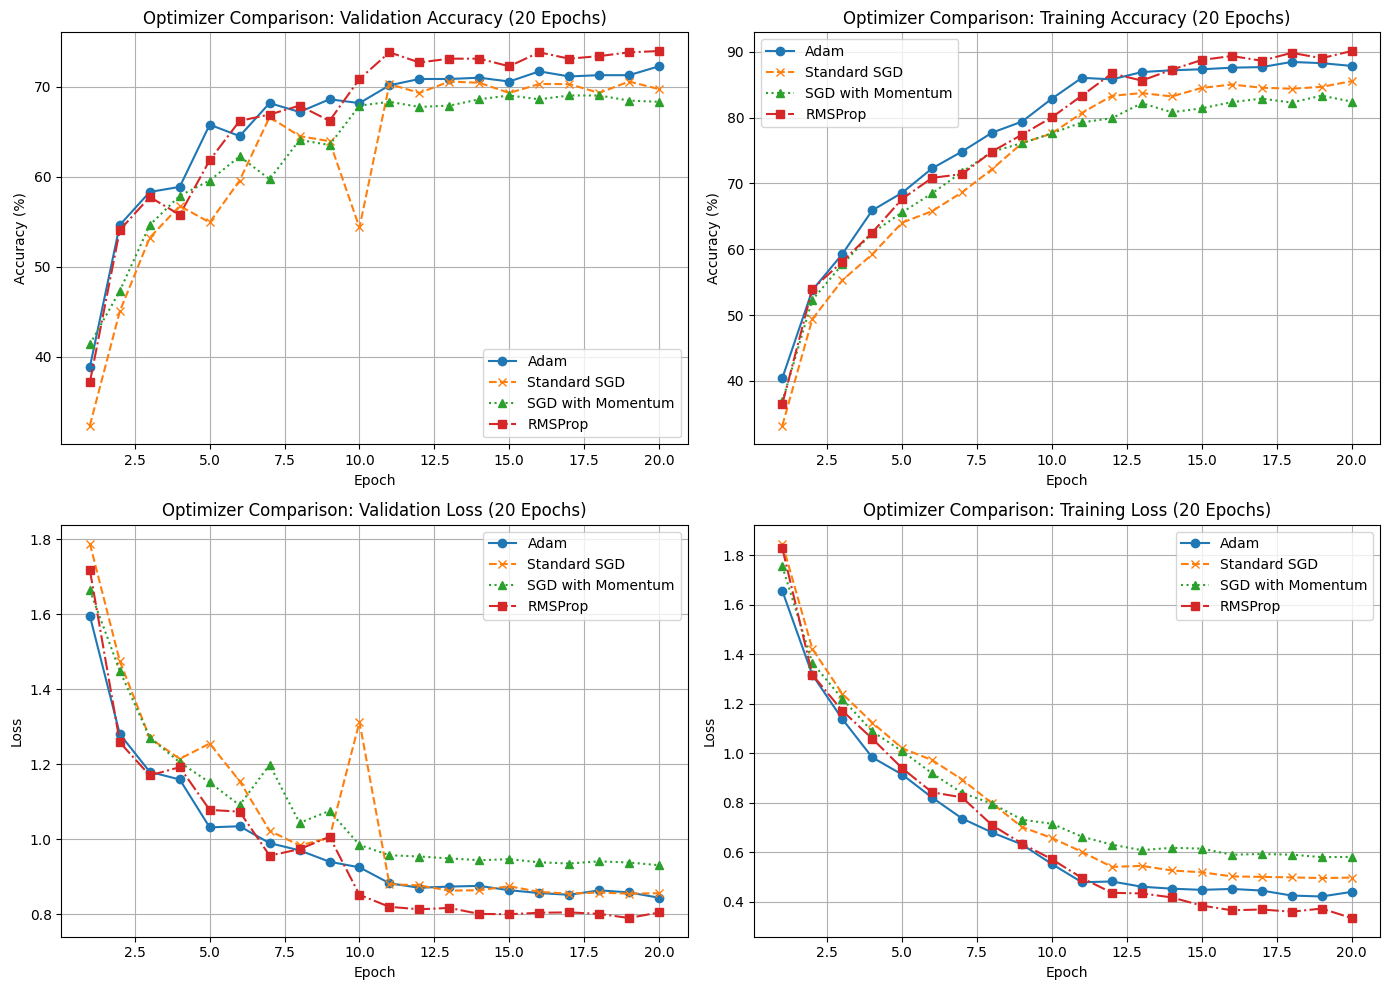


Optimizer Comparison plots generated.


In [55]:
plt.figure(figsize=(14, 10))

# === Plot 1: Validation Accuracy ===
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_val_accuracies, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Validation Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# === Plot 2: Training Accuracy ===
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_train_accuracies, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Training Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# === Plot 3: Validation Loss ===
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_val_losses, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Validation Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# === Plot 4: Training Loss ===
plt.subplot(2, 2, 4)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_train_losses, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Training Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nOptimizer Comparison plots generated.")


In [56]:
def evaluate_on_test_set_comp(model_instance, model_path, test_loader_comp, device_comp):
    model_instance.load_state_dict(torch.load(model_path))
    model_instance.to(device_comp)
    model_instance.eval()

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        test_loop = tqdm(test_loader_comp, desc=f"Evaluating Test Set for model from {model_path}", leave=False)
        for images, labels in test_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)
            outputs = model_instance(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy


print("\n--- Evaluating Comparison Models on Test Set ---")

adam_final_test_accuracy = evaluate_on_test_set_comp(model_adam_comp, adam_comp_model_path, test_loader, device)
sgd_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_comp, sgd_comp_model_path, test_loader, device)
sgd_momentum_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device)
rmsprop_final_test_accuracy = evaluate_on_test_set_comp(model_rmsprop_comp, rmsprop_comp_model_path, test_loader, device)


print("\n" + "="*75)
print("       Optimizer Performance Comparison Summary       ")
print("="*75 + "\n")
print(f"Final Test Accuracy for Adam: {adam_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for Standard SGD: {sgd_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for SGD with Momentum: {sgd_momentum_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for RMSProp: {rmsprop_final_test_accuracy:.2f}%")

print("\nOptimizer Comparison Test Evaluation Complete.")



--- Evaluating Comparison Models on Test Set ---



       Optimizer Performance Comparison Summary       

Final Test Accuracy for Adam: 73.16%
Final Test Accuracy for Standard SGD: 71.07%
Final Test Accuracy for SGD with Momentum: 69.82%
Final Test Accuracy for RMSProp: 74.13%

Optimizer Comparison Test Evaluation Complete.



--- Generating Confusion Matrices for All Optimizers ---


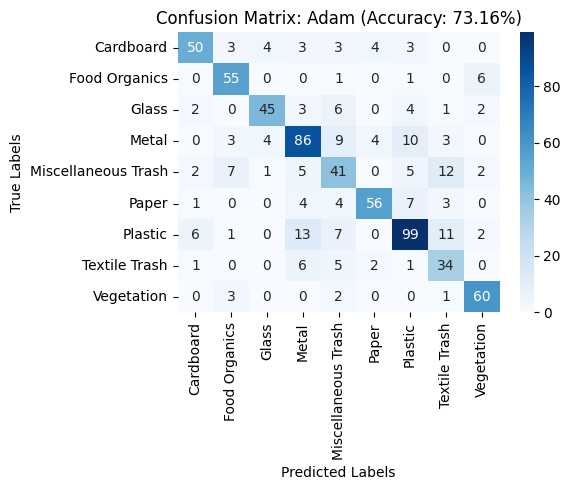

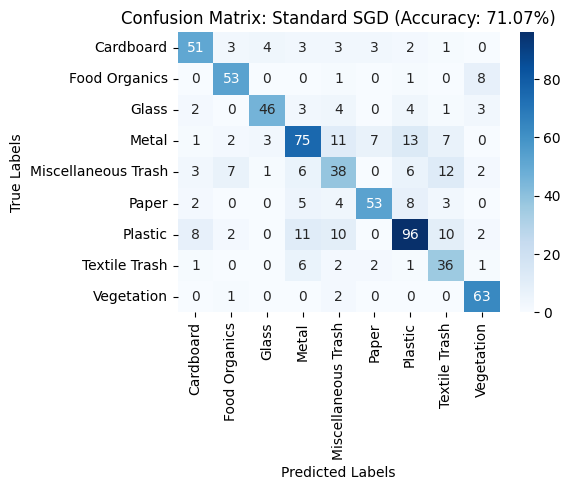

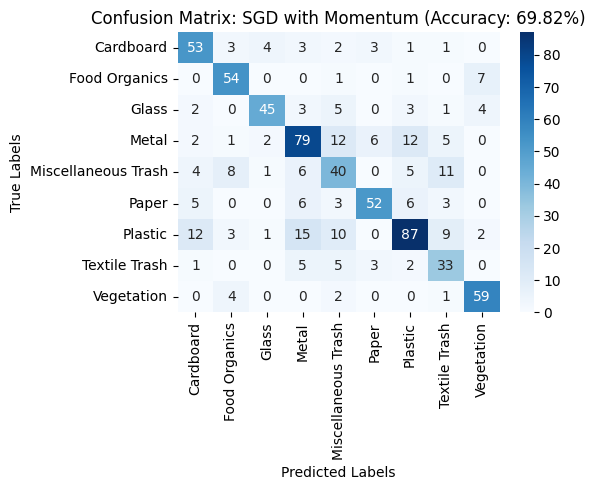

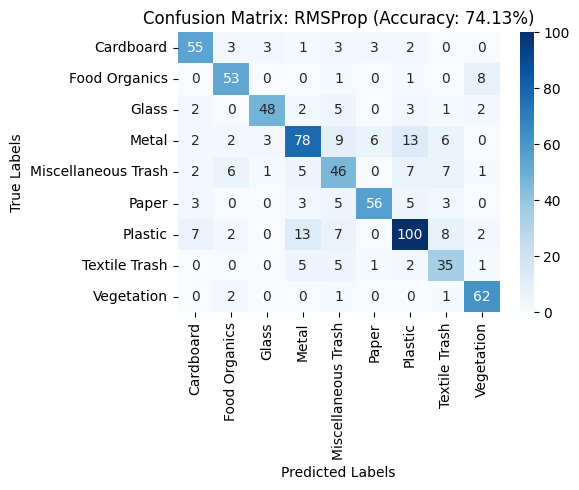


Confusion matrices generated for all optimizer models.


In [57]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, model_path, test_loader, device, optimizer_name, class_names=None):

    # Load model weights
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    acc = 100 * np.trace(cm) / np.sum(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix: {optimizer_name} (Accuracy: {acc:.2f}%)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()


# === Example: Generate confusion matrix for each optimizer ===
print("\n--- Generating Confusion Matrices for All Optimizers ---")

class_names = test_loader.dataset.classes if hasattr(test_loader.dataset, "classes") else None

plot_confusion_matrix(model_adam_comp, adam_comp_model_path, test_loader, device, "Adam", class_names)
plot_confusion_matrix(model_sgd_comp, sgd_comp_model_path, test_loader, device, "Standard SGD", class_names)
plot_confusion_matrix(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device, "SGD with Momentum", class_names)
plot_confusion_matrix(model_rmsprop_comp, rmsprop_comp_model_path, test_loader, device, "RMSProp", class_names)

print("\nConfusion matrices generated for all optimizer models.")


In [58]:
from sklearn.metrics import classification_report

def generate_classification_report(model, model_path, test_loader, device, optimizer_name, class_names=None):
    # Load model weights
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print(f"\n=== Classification Report: {optimizer_name} ===")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


# === Generate reports for all optimizers ===
print("\n--- Generating Classification Reports for All Optimizers ---")

generate_classification_report(model_adam_comp, adam_comp_model_path, test_loader, device, "Adam", class_names)
generate_classification_report(model_sgd_comp, sgd_comp_model_path, test_loader, device, "Standard SGD", class_names)
generate_classification_report(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device, "SGD with Momentum", class_names)
generate_classification_report(model_rmsprop_comp, rmsprop_comp_model_path, test_loader, device, "RMSProp", class_names)

print("\n✅ Classification reports generated for all optimizer models.")



--- Generating Classification Reports for All Optimizers ---

=== Classification Report: Adam ===
                     precision    recall  f1-score   support

          Cardboard     0.8065    0.7143    0.7576        70
      Food Organics     0.7639    0.8730    0.8148        63
              Glass     0.8333    0.7143    0.7692        63
              Metal     0.7167    0.7227    0.7197       119
Miscellaneous Trash     0.5256    0.5467    0.5359        75
              Paper     0.8485    0.7467    0.7943        75
            Plastic     0.7615    0.7122    0.7361       139
      Textile Trash     0.5231    0.6939    0.5965        49
         Vegetation     0.8333    0.9091    0.8696        66

           accuracy                         0.7316       719
          macro avg     0.7347    0.7370    0.7326       719
       weighted avg     0.7398    0.7316    0.7332       719


=== Classification Report: Standard SGD ===
                     precision    recall  f1-score   support

In [59]:
from torchvision import models

NUM_EPOCHS = 20
criterion = nn.CrossEntropyLoss()

train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


val_dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


train_loader_new = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_new = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_new = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

dataloaders = {'train': train_loader_new, 'val': val_loader_new, 'test': test_loader_new}



In [60]:
from torchvision.models import AlexNet_Weights, DenseNet121_Weights

# --- AlexNet ---
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)
for param in alexnet.features.parameters():
    param.requires_grad = False
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet = alexnet.to(device)

# --- DenseNet121 ---
densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
for param in densenet.features.parameters():
    param.requires_grad = False
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)
densenet = densenet.to(device)


In [61]:
def train_and_validate(model, model_name, optimizer, criterion, dataloaders, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(dataloaders['train'], desc=f"{model_name} Epoch {epoch+1}/{num_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(dataloaders['train'])
        train_acc = 100 * correct / total

        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(dataloaders['val'], desc=f"{model_name} Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(dataloaders['val'])
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"{model_name} Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    torch.save(model.state_dict(), f"{model_name.lower()}_finetuned.pth")
    print(f"\n{model_name} fine-tuning complete!\n")
    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
optimizer_alex = optim.Adam(alexnet.classifier.parameters(), lr=5e-5)
alex_train_losses, alex_val_losses, alex_train_accs, alex_val_accs = train_and_validate(
    alexnet, "AlexNet", optimizer_alex, criterion, dataloaders, num_epochs=NUM_EPOCHS
)

optimizer_dense = optim.Adam(densenet.classifier.parameters(), lr=0.001)
dense_train_losses, dense_val_losses, dense_train_accs, dense_val_accs = train_and_validate(
    densenet, "DenseNet121", optimizer_dense, criterion, dataloaders, num_epochs=NUM_EPOCHS
)


AlexNet Epoch 1/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [1/20] - Train Loss: 1.5059, Val Loss: 0.9386, Train Acc: 46.83%, Val Acc: 63.38%


AlexNet Epoch 2/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [2/20] - Train Loss: 0.9956, Val Loss: 0.7547, Train Acc: 64.73%, Val Acc: 70.42%


AlexNet Epoch 3/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [3/20] - Train Loss: 0.8697, Val Loss: 0.6678, Train Acc: 69.61%, Val Acc: 74.08%


AlexNet Epoch 4/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [4/20] - Train Loss: 0.8008, Val Loss: 0.6155, Train Acc: 72.31%, Val Acc: 76.90%


AlexNet Epoch 5/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [5/20] - Train Loss: 0.7466, Val Loss: 0.6169, Train Acc: 73.37%, Val Acc: 77.46%


AlexNet Epoch 6/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [6/20] - Train Loss: 0.6797, Val Loss: 0.5966, Train Acc: 75.87%, Val Acc: 77.18%


AlexNet Epoch 7/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [7/20] - Train Loss: 0.6889, Val Loss: 0.5254, Train Acc: 75.56%, Val Acc: 80.28%


AlexNet Epoch 8/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [8/20] - Train Loss: 0.6337, Val Loss: 0.5377, Train Acc: 77.37%, Val Acc: 78.87%


AlexNet Epoch 9/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [9/20] - Train Loss: 0.5994, Val Loss: 0.5175, Train Acc: 78.96%, Val Acc: 80.00%


AlexNet Epoch 10/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


AlexNet Epoch [10/20] - Train Loss: 0.5660, Val Loss: 0.5113, Train Acc: 79.87%, Val Acc: 81.55%


AlexNet Epoch 11/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [11/20] - Train Loss: 0.5532, Val Loss: 0.4951, Train Acc: 80.50%, Val Acc: 82.54%


AlexNet Epoch 12/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [12/20] - Train Loss: 0.5358, Val Loss: 0.4877, Train Acc: 81.04%, Val Acc: 80.42%


AlexNet Epoch 13/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.44it/s]


AlexNet Epoch [13/20] - Train Loss: 0.5332, Val Loss: 0.4802, Train Acc: 80.95%, Val Acc: 80.85%


AlexNet Epoch 14/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


AlexNet Epoch [14/20] - Train Loss: 0.5127, Val Loss: 0.4902, Train Acc: 82.12%, Val Acc: 80.56%


AlexNet Epoch 15/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [15/20] - Train Loss: 0.5074, Val Loss: 0.4754, Train Acc: 81.82%, Val Acc: 82.25%


AlexNet Epoch 16/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [16/20] - Train Loss: 0.4526, Val Loss: 0.4673, Train Acc: 84.14%, Val Acc: 80.99%


AlexNet Epoch 17/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [17/20] - Train Loss: 0.4831, Val Loss: 0.4579, Train Acc: 83.06%, Val Acc: 82.25%


AlexNet Epoch 18/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [18/20] - Train Loss: 0.4525, Val Loss: 0.4576, Train Acc: 84.59%, Val Acc: 83.66%


AlexNet Epoch 19/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [19/20] - Train Loss: 0.4544, Val Loss: 0.4261, Train Acc: 84.20%, Val Acc: 84.23%


AlexNet Epoch 20/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [20/20] - Train Loss: 0.4433, Val Loss: 0.4296, Train Acc: 85.50%, Val Acc: 83.94%

AlexNet fine-tuning complete!



DenseNet121 Epoch 1/20 [Train]: 100%|██████████| 52/52 [00:41<00:00,  1.25it/s]


DenseNet121 Epoch [1/20] - Train Loss: 1.6706, Val Loss: 1.1638, Train Acc: 43.15%, Val Acc: 60.56%


DenseNet121 Epoch 2/20 [Train]: 100%|██████████| 52/52 [00:41<00:00,  1.26it/s]


DenseNet121 Epoch [2/20] - Train Loss: 1.1017, Val Loss: 0.8926, Train Acc: 65.87%, Val Acc: 69.15%


DenseNet121 Epoch 3/20 [Train]: 100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


DenseNet121 Epoch [3/20] - Train Loss: 0.9528, Val Loss: 0.7829, Train Acc: 69.40%, Val Acc: 70.99%


DenseNet121 Epoch 4/20 [Train]: 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


DenseNet121 Epoch [4/20] - Train Loss: 0.8534, Val Loss: 0.7299, Train Acc: 72.83%, Val Acc: 72.39%


DenseNet121 Epoch 5/20 [Train]: 100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


DenseNet121 Epoch [5/20] - Train Loss: 0.8078, Val Loss: 0.6728, Train Acc: 72.86%, Val Acc: 74.08%


DenseNet121 Epoch 6/20 [Train]: 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


DenseNet121 Epoch [6/20] - Train Loss: 0.7539, Val Loss: 0.6909, Train Acc: 75.47%, Val Acc: 73.52%


DenseNet121 Epoch 7/20 [Train]:  65%|██████▌   | 34/52 [00:26<00:14,  1.25it/s]

In [ ]:
plt.figure(figsize=(12, 10))

# === 1️⃣ AlexNet: Loss ===
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), alex_train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), alex_val_losses, label='Validation Loss')
plt.title("AlexNet: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# === 2️⃣ AlexNet: Accuracy ===
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), alex_train_accs, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), alex_val_accs, label='Validation Accuracy')
plt.title("AlexNet: Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# === 3️⃣ DenseNet121: Loss ===
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), dense_train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), dense_val_losses, label='Validation Loss')
plt.title("DenseNet121: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# === 4️⃣ DenseNet121: Accuracy ===
plt.subplot(2, 2, 4)
plt.plot(range(1, NUM_EPOCHS + 1), dense_train_accs, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), dense_val_accs, label='Validation Accuracy')
plt.title("DenseNet121: Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Final Summary ===
print("\nFinal Accuracy Summary:")
print(f"AlexNet - Train Accuracy: {alex_train_accs[-1]:.2f}%, Validation Accuracy: {alex_val_accs[-1]:.2f}%")
print(f"DenseNet121 - Train Accuracy: {dense_train_accs[-1]:.2f}%, Validation Accuracy: {dense_val_accs[-1]:.2f}%")


In [ ]:
def plot_confusion_matrix_new(model, model_name, model_path, test_loader, class_names):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = 100 * np.trace(cm) / np.sum(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name} (Accuracy: {acc:.2f}%)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

print("\n--- Generating Confusion Matrices ---")
plot_confusion_matrix_new(alexnet, "AlexNet", "alexnet_finetuned.pth", test_loader, train_dataset.classes)
plot_confusion_matrix_new(densenet, "DenseNet121", "densenet121_finetuned.pth", test_loader, train_dataset.classes)


In [ ]:
from sklearn.metrics import classification_report

def generate_classification_report_new(model, model_name, model_path, test_loader, class_names):
    
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print(f"\n=== Classification Report: {model_name} ===")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


print("\n--- Generating Classification Reports ---")
generate_classification_report_new(alexnet, "AlexNet", "alexnet_finetuned.pth", test_loader, train_dataset.classes)
generate_classification_report_new(densenet, "DenseNet121", "densenet121_finetuned.pth", test_loader, train_dataset.classes)
print("\nClassification reports generated for both models.")
